In [ ]:
# Install the kaggle library using pip
! pip install kaggle

# Creat a new directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=9b2ce525c83cad160fa6e58073017e624811cac24e3c3a92ef682f09710e4040
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%pylab inline
import plotly.express as px
import time

#evaluation and feature engineering
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour,NearMiss,EditedNearestNeighbours, RandomUnderSampler
from datetime import datetime, date

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,\
                                       NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import regexp_replace, col
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Download the European Credit Card Fraud Dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud
!mkdir -p "/content/drive/My Drive/mlg-ulb/creditcardfraud/"

!cp creditcardfraud.zip "/content/drive/My Drive/mlg-ulb/creditcardfraud/"
!unzip "/content/drive/My Drive/mlg-ulb//creditcardfraud/creditcardfraud.zip"

 76% 50.0M/66.0M [00:00<00:00, 137MB/s]
100% 66.0M/66.0M [00:00<00:00, 142MB/s]
Archive:  /content/drive/My Drive/mlg-ulb//creditcardfraud/creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
# Read the European credit card dataset.
df = pd.read_csv("creditcard.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Check the first 5 rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Check Summary statistics
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# Check for missing values in the DataFrame
missing_values = df.isna().sum()
print("Missing values before treatment:")
print(missing_values)

Missing values before treatment:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [ ]:
# Check for positive or negative infinity in the DataFrame.
positive_inf_count = (df == np.inf).sum().sum()
print(f"Total positive infinity values in the DataFrame: {positive_inf_count}")
negative_inf_count = (df == -np.inf).sum().sum()
print(f"Total negative infinity values in the DataFrame: {negative_inf_count}")

Total positive infinity values in the DataFrame: 0
Total negative infinity values in the DataFrame: 0


In [ ]:
# Select a fraction of the european credit card dataset
df = df.sample(frac=0.3) # Get 30% of the data
len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85442 entries, 191778 to 261434
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    85442 non-null  float64
 1   V1      85442 non-null  float64
 2   V2      85442 non-null  float64
 3   V3      85442 non-null  float64
 4   V4      85442 non-null  float64
 5   V5      85442 non-null  float64
 6   V6      85442 non-null  float64
 7   V7      85442 non-null  float64
 8   V8      85442 non-null  float64
 9   V9      85442 non-null  float64
 10  V10     85442 non-null  float64
 11  V11     85442 non-null  float64
 12  V12     85442 non-null  float64
 13  V13     85442 non-null  float64
 14  V14     85442 non-null  float64
 15  V15     85442 non-null  float64
 16  V16     85442 non-null  float64
 17  V17     85442 non-null  float64
 18  V18     85442 non-null  float64
 19  V19     85442 non-null  float64
 20  V20     85442 non-null  float64
 21  V21     85442 non-null  float

In [ ]:
# Initialize the MinMaxScaler.
cols= df.columns
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(df)
df = pd.DataFrame(minmax_df, columns =df.columns)

In [ ]:
# Seperate the feautures (input data) from the target variable.
X= df.drop(columns = 'Class')
y= df['Class']

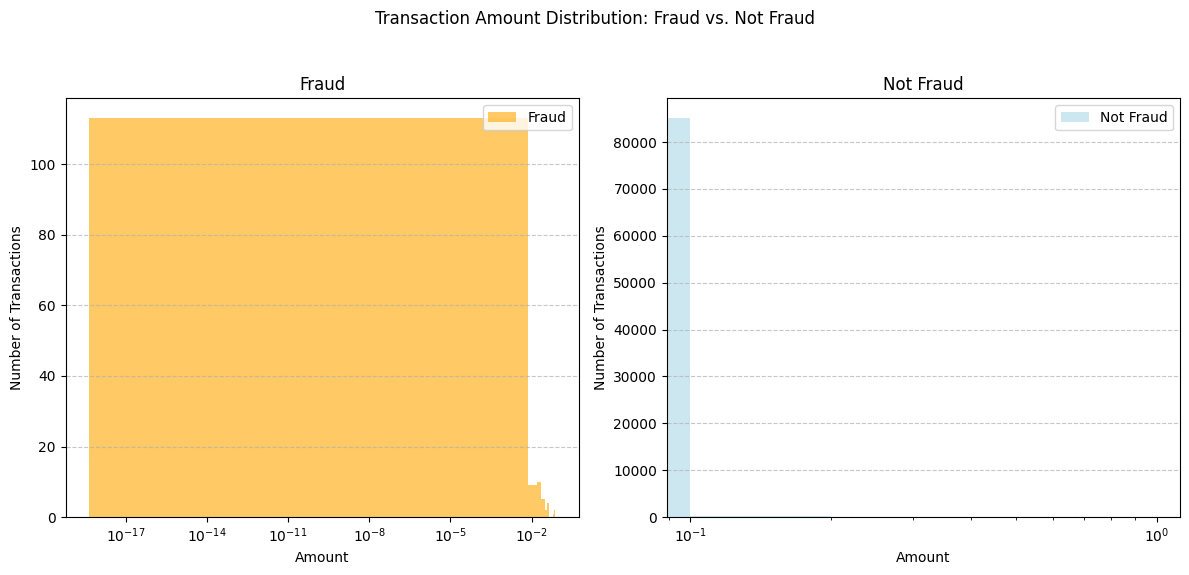

In [ ]:
# Visualise to show level of class imbalance in european creditcard Fraud Dataset
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Fraud histogram
ax1.hist(df.Amount[df.Class == 1], bins=10, alpha=0.6, color='orange', label='Fraud')
ax1.set_title('Fraud')
ax1.set_xlabel('Amount')
ax1.set_ylabel("Number of Transactions")
ax1.set_xscale('log')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Not Fraud histogram
ax2.hist(df.Amount[df.Class == 0], bins=10, alpha=0.6, color='lightblue', label='Not Fraud')
ax2.set_title('Not Fraud')
ax2.set_xlabel('Amount')
ax2.set_ylabel("Number of Transactions")
ax2.set_xscale('log')
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.legend()

plt.suptitle("Transaction Amount Distribution: Fraud vs. Not Fraud")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some spacing for the main title
plt.show()


In [ ]:
# Import the RandomUnderSampler class from the imbalanced-learn library.
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of the RandomUnderSampler class
rus = RandomUnderSampler(
      sampling_strategy='auto', # resampling the majority class
      random_state=0,
      replacement=True
      )

# Apply the under-sampling technique on the dataset (X and y).
X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
# Add a new column named 'Class' to the DataFrame `X_resampled`
X_resampled['Class'] = y_resampled

In [ ]:
# Check the first five rows for validation
X_resampled.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.290370,0.967917,0.758604,0.932618,0.273322,0.524347,0.514468,0.439991,0.804599,0.584035,...,0.560109,0.515102,0.649401,0.420950,0.601453,0.608967,0.484925,0.352763,0.000051,0.0
1,0.259182,0.970688,0.768787,0.897616,0.258483,0.546063,0.493674,0.458799,0.798532,0.493012,...,0.558233,0.486358,0.649844,0.370943,0.614009,0.498309,0.483173,0.352596,0.000203,0.0
2,0.370768,0.964985,0.770388,0.914247,0.366679,0.538912,0.485044,0.460347,0.796856,0.462189,...,0.564022,0.516290,0.646546,0.465258,0.619759,0.427258,0.484264,0.354857,0.005774,0.0
3,0.275427,0.976615,0.758766,0.904404,0.191276,0.527296,0.474727,0.449218,0.794575,0.376875,...,0.558962,0.510473,0.650699,0.472666,0.617977,0.385858,0.487501,0.353862,0.000763,0.0
4,0.730129,0.965069,0.780569,0.857370,0.302115,0.566335,0.490919,0.475472,0.792243,0.449539,...,0.562960,0.537896,0.650027,0.443792,0.537375,0.520593,0.484751,0.355213,0.000853,0.0


In [ ]:
# Save DataFrame to a CSV file
X_resampled.to_csv("file1.csv")

In [ ]:
# read the CSV file into a Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('empirical-evaluation').getOrCreate()
df = spark.read.csv('file1.csv', header = True, inferSchema = True)
df.printSchema()
cols=df.columns

root
 |-- _c0: integer (nullable = true)
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (null

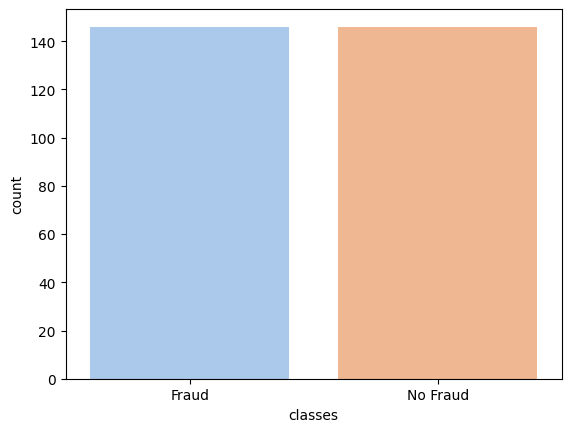

In [ ]:
# check the level of class imbalance after applying the sampling technique.
import seaborn as sns
import matplotlib.pyplot as plt
label_class=df.groupBy('Class').count().toPandas()
sns.barplot(x=['Fraud','No Fraud',],y=label_class['count'], palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# Check summary statistics for each column
df.describe().toPandas()

,summary,_c0,Time,V1,V2,V3,V4,V5,V6,V7,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,292,292,292,292,292,292,292,292,292,...,292,292,292,292,292,292,292,292,292,292
1,mean,145.5,0.4996978278328191,0.8942579914888028,0.788928391245521,0.8104365040148062,0.3454277211556647,0.5298197265354676,0.47671931660056777,0.428803019275856,...,0.5671352494394979,0.5132222849306411,0.6502101554559699,0.40498088075971045,0.6003664345919699,0.4295085545289962,0.4897510169334683,0.3558982611674497,0.005651314841735919,0.5
2,stddev,84.43735350345051,0.2796033322004541,0.11024738851606032,0.039926537395594784,0.15196099026169113,0.1357813696513473,0.05843842713344622,0.04075002163442249,0.07268243524273005,...,0.034864294070112586,0.04517456072127775,0.013271222961955773,0.08539216979400964,0.04101351944737406,0.0805893340206978,0.04751334445029768,0.016803518413905094,0.011706330565773644,0.5008583697306153
3,min,0,0.00216447711094392,0.2940463609736558,0.6796063130703609,0.09252120637193495,0.05686156340430992,0.23201095484373474,0.3409551585931828,0.008269213279691434,...,0.4203341899117845,0.09545177464382071,0.5877246115620234,0.11580976323203318,0.4355091689475188,0.16363139064247312,0.12898815561714366,0.294993830520438,0.0,0.0
4,max,291,0.9971526129984374,0.9928047847905476,0.9707590973740996,0.9756308208729009,0.7850556801552786,0.6471273675978597,0.6277606770066926,0.5330522929226388,...,0.9999999999999999,0.671481622427845,0.7536466122233413,0.5987359186537283,0.7351738788126116,0.8724179839460735,0.6002793920775281,0.4254868125131884,0.07656132593087386,1.0


In [ ]:
# feature scaling and vector assembling
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (null

In [ ]:
# Instantiate a `VectorAssembler` object and transform
sel_cols = df.columns
assembler = VectorAssembler(inputCols = sel_cols, outputCol = "features_vectorize")
data = assembler.transform(df)

In [ ]:
# Select distinct values from the "Class" column, order them in ascending order,
# and then collect the values into a list.
label_list = data.select(['Class']).distinct().orderBy('Class').select('Class').rdd.flatMap(lambda x: x).collect()

In [ ]:
# Quick inspection of the data using the first 5 rows
pd.DataFrame(data.take(5),columns=data.columns)

,_c0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,features_vectorize
0,0,0.290370,0.967917,0.758604,0.932618,0.273322,0.524347,0.514468,0.439991,0.804599,...,0.515102,0.649401,0.420950,0.601453,0.608967,0.484925,0.352763,0.000051,0.0,"[0.0, 0.2903698130678859, 0.9679170231637856, ..."
1,1,0.259182,0.970688,0.768787,0.897616,0.258483,0.546063,0.493674,0.458799,0.798532,...,0.486358,0.649844,0.370943,0.614009,0.498309,0.483173,0.352596,0.000203,0.0,"[1.0, 0.2591816656056485, 0.9706880664253481, ..."
2,2,0.370768,0.964985,0.770388,0.914247,0.366679,0.538912,0.485044,0.460347,0.796856,...,0.516290,0.646546,0.465258,0.619759,0.427258,0.484264,0.354857,0.005774,0.0,"[2.0, 0.3707679842583483, 0.9649849183559313, ..."
3,3,0.275427,0.976615,0.758766,0.904404,0.191276,0.527296,0.474727,0.449218,0.794575,...,0.510473,0.650699,0.472666,0.617977,0.385858,0.487501,0.353862,0.000763,0.0,"[3.0, 0.27542681868163665, 0.9766149299593843,..."
4,4,0.730129,0.965069,0.780569,0.857370,0.302115,0.566335,0.490919,0.475472,0.792243,...,0.537896,0.650027,0.443792,0.537375,0.520593,0.484751,0.355213,0.000853,0.0,"[4.0, 0.730129058394583, 0.9650691148552776, 0..."


In [ ]:
# Split dataset into train and test
train, test = data.randomSplit([0.8, 0.2], seed = 12)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 237
Test Dataset Count: 55


In [ ]:
# Group by 'label' column and count number of occurences
# Convert to a Pandas DataFrame for easier manipulation.
train_label=train.groupBy('Class').count().toPandas()
test_label=test.groupBy('Class').count().toPandas()

In [ ]:
# extract the counts of each unique value in the 'Class' column
# from both the train and test and combine in a single list.
items1=[i for i in train_label['count'].values]
items2=[i for i in test_label['count'].values]
items=items1+items2

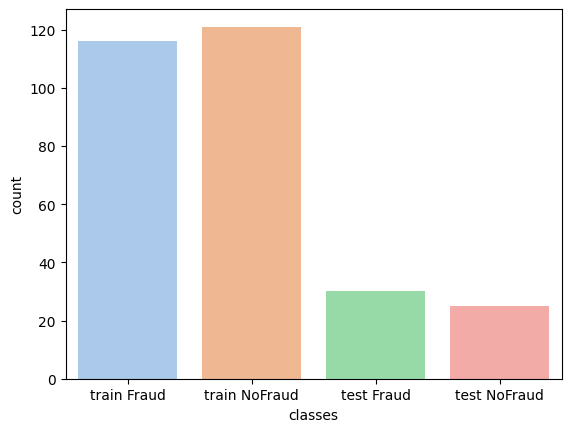

In [ ]:
# Create a bar plot using seaborn.
classes=['train Fraud',"train NoFraud","test Fraud","test NoFraud"]
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=classes,y=items, palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

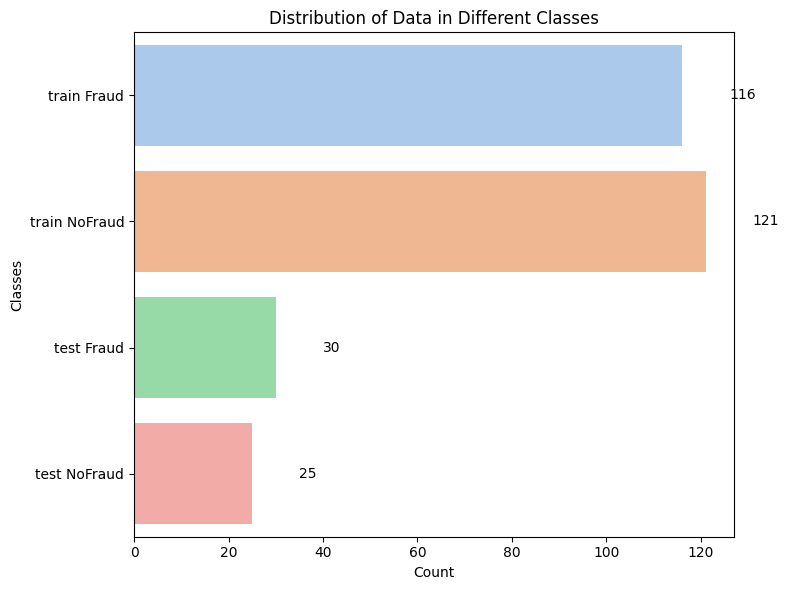

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

classes = ['train Fraud', 'train NoFraud', 'test Fraud', 'test NoFraud']

# Create a horizontal bar plot
plt.figure(figsize=(8, 6))
colors = sns.color_palette("pastel")
ax = sns.barplot(x=items, y=classes, palette=colors)

for i, v in enumerate(items):
    ax.text(v + 10, i, str(v), color='black', va='center')

plt.xlabel('Count')
plt.ylabel('Classes')
plt.title('Distribution of Data in Different Classes')

plt.tight_layout()

plt.show()



Models Evaluation:
------------------------
Logistic Regression
now running Logistic Regression model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Decision Tree
now running Decision Tree model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Random Forest
now running Random Forest model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Naive Bayes Multinomial
now running Naive Bayes Multinomial model
accuracy = 0.98
weightedPrecision = 0.98
weightedRecall = 0.98
f1 = 0.98


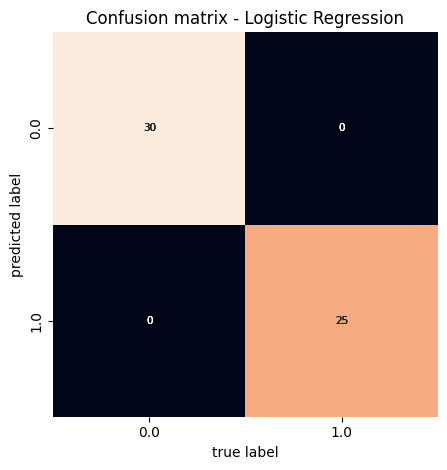

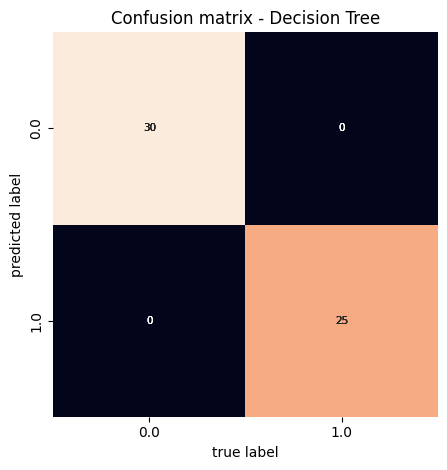

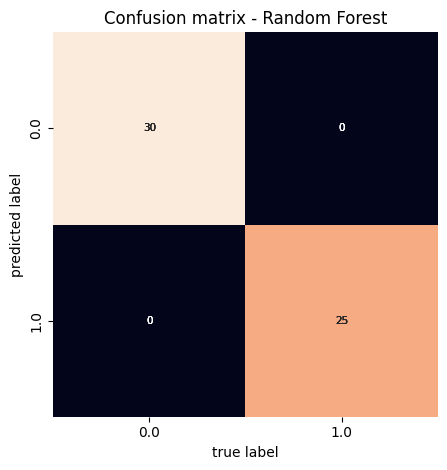

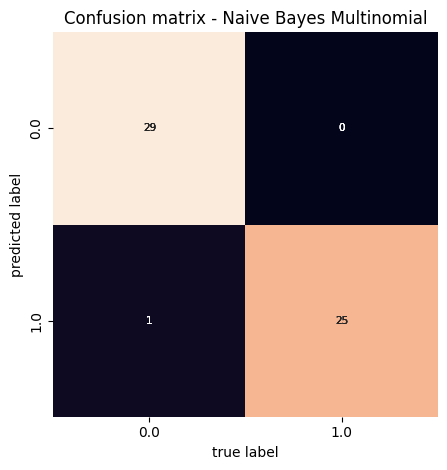

In [ ]:
# Initialize Logistic Regression model with specified hyperparameters
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol = 'features_vectorize',
                        labelCol = 'Class', family="multinomial")

# Initialise Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'features_vectorize', labelCol = 'Class')

# Initialise Random Forest model with 20 trees
rf = RandomForestClassifier(labelCol='Class', featuresCol='features_vectorize', numTrees=20)

# Initialise Naive Bayes Multinomial model
nb = NaiveBayes(labelCol='Class', featuresCol='features_vectorize', smoothing=1.0, modelType="multinomial")

# Store models in a dictionary for easier iteration
classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
               "Random Forest": rf, "Naive Bayes Multinomial": nb}
# Define evaluation metrics to be computed for each model
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

print("\nModels Evaluation:")
print("{:-<24}".format(""))
# Iterate through each classifier
for idx, c in enumerate(classifiers):
  print(c)

	# Fit the model on the training data
  print(f'now running {c} model')
  model = classifiers[c].fit(train)

  # Use the trained model to make predictions on the test data
  predictions = model.transform(test)
  predictions.cache()

  # Evaluate the performance of the model using PySpark's MulticlassClassificationEvaluator
  evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol="prediction")
  for m in metrics:
    evaluator.setMetricName(m)
    metric = evaluator.evaluate(predictions)
    print("{name} = {value:.2f}".format(name=m, value=metric))

    # Build confusion matrix using Scikit-learn
    target_list = predictions.select('Class').rdd.flatMap(lambda x: x).collect()
    pred_list = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    label_num_list = predictions.select('Class').distinct().orderBy('Class').rdd.flatMap(lambda x: x).collect()
    # print("\nClassification report using Sklearn:")
    # print(classification_report(target_list, pred_list, target_names=label_list))

    # Compute and visualize the confusion matrix using seaborn
    conf_matrix = confusion_matrix(target_list, pred_list)
    plt.figure(idx)
    plt.title("Confusion matrix - {model}".format(model=c))
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
	            annot_kws={"size": 7.5}, xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()

# Display all the confusion matrix plots
plt.show()